In [42]:
import pickle
from connections.mysql_connector import MySQL_Connector
from models.topic_modeling import Topic_Modeling
from connections.neo4j_connector import Neo4j_Connector
import os
from datetime import datetime
from gensim import corpora, models, similarities
from models.graph_generator import Graph_Generator
from models.tuple_extractor import Tuple_Extractor
from acessos import read, get_conn, persistir_uma_linha, persistir_multiplas_linhas, replace_df
import pandas as pd
import re
import numpy as np
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.parsing.preprocessing import strip_punctuation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np
import credentials

In [2]:
nlp = spacy.load("pt_core_news_lg")

connector = MySQL_Connector("conn_orfeu")
conn = connector.return_conn("influencer_br")

neo4j_client = Neo4j_Connector(credentials.neo4j_uri, credentials.neo4j_user, credentials.neo4j_password)
graph_generator = Graph_Generator(neo4j_client)

tuple_extractor = Tuple_Extractor()

  --> Carregando modelo Spacy
Pronto.


In [3]:
def gerar_tuplas(texto):
    tuple_extractor.extrair_tupla(texto)
    df_tuplas = tuple_extractor.get_ultimas_tuplas_geradas()
    
    return df_tuplas

def gerar_df_doc(texto, video_id=""):
    if video_id !="":
        data =  {'nome': [texto], 'type': ["DOC"], 'id': [video_id]}
    else:
        data =  {'nome': [texto], 'type': ["DOC"]}
    
    df_doc = pd.DataFrame(data=data)
    return df_doc

def pre_processar_tuplas(df_tuplas):
    df_tuplas['arg1'] = df_tuplas.apply(lambda x: graph_generator.pre_process_text(x['arg1']), axis=1) 
    df_tuplas['arg2'] = df_tuplas.apply(lambda x: graph_generator.pre_process_text(x['arg2']), axis=1) 
    df_tuplas['rel'] = df_tuplas.apply(lambda x: graph_generator.pre_process_text(x['rel'], rel=True), axis=1) 
    
    return df_tuplas

def get_df_sentencas(df_tuplas):
    df_sentencas = pd.DataFrame()
    df_sentencas['nome'] = df_tuplas['sentenca']#.to_frame()
    df_sentencas['type'] = "SENTENÇA"
    df_sentencas.drop_duplicates(subset=['nome'], inplace=True)
    return df_sentencas

def processar_df_tuplas(df_tuplas):
    
    df_arg1 = df_tuplas[['arg1']]
    df_arg1['type'] = "ARG1"
    df_arg1 = df_arg1.rename(columns={"arg1": 'nome'})
    
    
    df_arg2 = df_tuplas[['arg2']]
    df_arg2['type'] = "ARG2"
    df_arg2 = df_arg2.rename(columns={"arg2": 'nome'})
    
    return df_arg1, df_arg2

def gerar_relacao_doc_sentenca(texto, df_sentencas):
    #ATENÇÃO usar somente após a criação dos nós sentenças e doc
    for sentenca in df_sentencas.iterrows():
        neo4j_client.criar_relacao_de_para(texto, sentenca[1]['nome'], "DOC", sentenca[1]['type'], "extraiu")

def gerar_relacao_arg1_rel_arg2(df_tuplas):
    #ATENÇÃO usar somente após a criação dos nós arg1, arg2 e rel
    for linha in df_tuplas.iterrows():
        relacao = "RELAÇÃO_TUPLA {rel:'" + linha[1]["rel"] + "'}"
        neo4j_client.criar_relacao_de_para(linha[1]["arg1"], linha[1]['arg2'], "ARG1", "ARG2", relacao)
        

def gerar_relacao_sentenca_arg1(df_tuplas): #estou chamando de relação cabeça
    for linha in df_tuplas.iterrows():
        neo4j_client.criar_relacao_de_para(linha[1]["sentenca"], linha[1]['arg1'], "SENTENÇA", "ARG1", "extraiu")
        
def processar_texto_entrada(texto): #Remover emojis tag [Musica]... e as aspas
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    
    texto = re.sub(r"\[.*?\]\s*", "", texto)
    texto = texto.replace("'", "")
    texto = texto.replace('"', "")
    texto = texto.replace('\n', " ")
    #texto = texto.rstrip("\n")
    texto = emoji_pattern.sub(r'', texto)
    
    return texto

def calcular_similaridade_jaccard(texto1, texto2):
    texto1 = str(texto1).lower()
    texto1 = strip_punctuation(texto1)
    
    texto2 = str(texto2).lower()
    texto2 = strip_punctuation(texto2)
    
    s1 = set(texto1.split())
    s2 = set(texto2.split())
          
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))


def calcular_similaridade_cos(texto1, texto2):
    texto1 = str(texto1).lower()
    texto1 = strip_punctuation(texto1)
    
    texto2 = str(texto2).lower()
    texto2 = strip_punctuation(texto2)
    
    tfidf_vectorizer = TfidfVectorizer()
    list_doc = (texto1, texto2)
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(list_doc)
    
    similaridade = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
    return similaridade

def obter_embedding(texto):
    return nlp(texto).vector



In [4]:
#texto = "João mora com maria. João é muito feliz. Maria tem um cachorro chamado Mike. Mike é muito espuleta"
#texto = "O curso de sistemas de informação, permite ao estudante a resolução de problemas de diferentes áreas de conhecimento. Além disso, ele fornece um forte embasamento matemático e de programação."
#texto = "Como já disse a vocês , en o meu curso eu consigo aprofundar isso com os alunos um pouco mais porque tive que falar de gorduras e aí pra vocês entenderem as diferenças de gorduras , de suplementos também , a curcumina por exemplo ajudaria mas a qualidade , as diferenças de qualidade , o momento de o dia que deve ser ingerido , qual o melhor aproveitamento por o corpo mas acho que como um todo vocês conseguiram ter uma boa ideia de a complexidade desse tema para não caírem nessas diversas ciladas que vocês acabam caindo por a internet . "
#texto = "O profissional formado em Ciência da Computação atua basicamente na elaboração de programas de informática."


connector = MySQL_Connector("conn_orfeu")
conn = connector.return_conn("influencer_br")

video_id = "1Rhoyr2MnFE"
query = "SELECT video_id, transcription_pt as texto FROM video_transcriptions where video_id = '{}';".format(video_id)

texto_bruto = read(conn, query)["texto"].loc[0]
texto_processado = processar_texto_entrada(texto_bruto)


df_doc = gerar_df_doc(texto_processado,video_id)

df_tuplas = gerar_tuplas(texto_processado)
df_tuplas = pre_processar_tuplas(df_tuplas)

df_sentencas = get_df_sentencas(df_tuplas)


 -> Salvando texto no input.txt
  -> Extraindo Tuplas...
Pronto :D


In [5]:
df_tuplas["id_sent"] = df_tuplas.apply(lambda x: 
                                       df_sentencas.index[df_sentencas['nome'] == x['sentenca']][0],
                                       axis=1)
df_tuplas.head()

,sentenca,arg1,rel,arg2,id_sent
1,"Meu Deus , esse é um vídeo urgente .",esse,é_um_vídeo,urgente,1
2,"Meu Deus , esse é um vídeo urgente .",esse,é,um vídeo urgente,1
3,"Hoje é dia 24 , que pesado hoje .",Hoje dia 24,pesado,hoje,3
4,"Sérgio Moro pediu demissão , Kaique .",Sérgio Moro,pediu,"demissão , Kaique",4
5,"Sérgio Moro pediu demissão , Kaique .",demissão,é,Kaique,4


## Obtendo os vetores

In [6]:
print("Sentenças...")
df_tuplas['word_embedding_sentenca'] = df_tuplas.apply(lambda x: obter_embedding(x['sentenca']), axis=1)

print("Arg1...")
df_tuplas['word_embedding_arg1'] = df_tuplas.apply(lambda x: obter_embedding(x['arg1']), axis=1)

print("Arg2...")
df_tuplas['word_embedding_arg2'] = df_tuplas.apply(lambda x: obter_embedding(x['arg2']), axis=1)

print("Rel...")
df_tuplas['word_embedding_rel'] = df_tuplas.apply(lambda x: obter_embedding(x['rel'].replace('_', " ")), axis=1)

print("Tupla Completa...")
df_tuplas['word_embedding_tupla_completa'] = df_tuplas.apply(lambda x: obter_embedding("{} {} {}".format(
                                                                                            x['arg1'],
                                                                                            x['rel'].replace('_', " "),
                                                                                            x['arg2'])),
                                                                                      axis=1)

df_tuplas['tupla_completa'] = df_tuplas.apply(lambda x: "{} {} {}".format(x['arg1'],
                                                                          x['rel'].replace('_', " "),
                                                                          x['arg2']),
                                              axis=1)

Sentenças...
Arg1...
Arg2...
Rel...
Tupla Completa...


In [7]:
df_word_sent = df_tuplas[["sentenca","word_embedding_sentenca","id_sent"]].drop_duplicates(subset=['sentenca']).rename(
    columns={"sentenca": "texto", "word_embedding_sentenca": "word_embedding"})
df_word_sent['label'] = "sent"

df_word_arg1 = df_tuplas[["arg1","word_embedding_arg1","id_sent"]].rename(
    columns={"arg1": "texto", "word_embedding_arg1": "word_embedding"})
df_word_arg1['label'] = "arg1"

df_word_arg2 = df_tuplas[["arg2","word_embedding_arg2","id_sent"]].rename(
    columns={"arg2": "texto", "word_embedding_arg2": "word_embedding"})
df_word_arg2['label'] = "arg2"

df_word_rel = df_tuplas[["rel","word_embedding_rel","id_sent"]].rename(
    columns={"rel": "texto", "word_embedding_rel": "word_embedding"})
df_word_rel['label'] = "rel"

df_word_tupla_completa = df_tuplas[["tupla_completa","word_embedding_tupla_completa","id_sent"]].rename(
    columns={"tupla_completa": "texto", "word_embedding_tupla_completa": "word_embedding"})
df_word_tupla_completa['label'] = "tupla_completa"

frames = [
    df_word_sent,
    df_word_arg1,
    df_word_arg2,
    df_word_rel,
    df_word_tupla_completa   
]


df_aux = pd.concat(frames, ignore_index=True)
df_aux.reset_index(drop=True)
# df_aux.reset_index(drop=True)


df_embeddings = pd.DataFrame(df_aux['word_embedding'].to_list())
df_embeddings = pd.concat([df_aux[["texto","label","id_sent"]],df_embeddings], axis=1)

df_embeddings.head()

,texto,label,id_sent,0,1,2,3,4,5,6,...,290,291,292,293,294,295,296,297,298,299
0,"Meu Deus , esse é um vídeo urgente .",sent,1,0.235137,0.636888,1.052129,3.287236,-0.512888,1.103339,0.159932,...,2.468221,3.873867,2.159297,2.052363,-0.422890,-2.286819,0.982944,0.099874,-0.457133,-0.293759
1,"Hoje é dia 24 , que pesado hoje .",sent,3,-1.955961,0.713277,0.128652,1.882253,-1.125728,-0.905651,-0.044492,...,0.652315,1.503221,0.233268,0.853424,0.898300,-1.312724,0.251883,-1.089461,0.680908,1.431826
2,"Sérgio Moro pediu demissão , Kaique .",sent,4,1.602586,0.286434,0.057316,1.274490,0.290687,-0.092973,-1.609861,...,0.060157,1.507869,-0.750823,0.116580,-0.093706,-0.308141,-1.075451,-1.009007,1.261987,0.415481
3,"O que você tem que fazer não é falar nada , Ka...",sent,7,0.336062,-0.447710,-1.500561,2.737168,-1.376308,0.350984,0.201384,...,1.527355,2.432307,0.625068,2.084363,0.287448,-2.106070,0.925305,1.398268,0.495029,0.494338
4,O que você tem que fazer é dizer para a gente ...,sent,9,0.594965,-0.446452,-1.183152,1.902780,-1.674212,-0.314895,0.217001,...,-0.192583,3.688965,0.663303,0.969537,0.439840,-1.825568,1.465641,1.237811,0.919623,-0.163259


### Normalizando os dados

In [8]:
features = df_embeddings.drop(["texto", "label","id_sent"], axis=1).columns.to_list()
array_valores = df_embeddings.loc[:, features].values
array_normalizado = StandardScaler().fit_transform(array_valores)

len(array_normalizado)

2769

## Reduzindo a dimensionalidade

In [9]:
tsne = TSNE()
tsne_results = tsne.fit_transform(array_normalizado)

componentes = tsne_results

componentes

array([[-33.385418, -17.369831],
       [-12.890845, -36.795742],
       [-14.37315 , -45.000847],
       ...,
       [-19.31134 ,  21.006588],
       [ 46.32835 ,  10.426004],
       [-15.769739,  22.678537]], dtype=float32)

In [10]:
df_tsne = pd.DataFrame(data=componentes)
df_tsne = pd.concat([df_aux[["texto","label","id_sent"]],df_tsne], axis=1)
df_tsne.head()

,texto,label,id_sent,0,1
0,"Meu Deus , esse é um vídeo urgente .",sent,1,-33.385418,-17.369831
1,"Hoje é dia 24 , que pesado hoje .",sent,3,-12.890845,-36.795742
2,"Sérgio Moro pediu demissão , Kaique .",sent,4,-14.373150,-45.000847
3,"O que você tem que fazer não é falar nada , Ka...",sent,7,-32.029552,-20.995506
4,O que você tem que fazer é dizer para a gente ...,sent,9,2.051564,-9.175020


### SALVANDO NO NEO4J

In [57]:
# persistindo documento
neo4j_client.add_nodes(df_doc)

# persistindo sentenças
lista_erro_sent = neo4j_client.add_nodes(df_sentencas.drop_duplicates(subset=['nome']))
print("Total de sentenças com erro: {}".format(len(lista_erro_sent)))

# #persistindo relação doc-sentença
# gerar_relacao_doc_sentenca(texto, df_sentencas)

# #Persistindo argumentos 
# df_arg1, df_arg2= processar_df_tuplas(df_tuplas)
# neo4j_client.add_nodes(df_arg1)
# neo4j_client.add_nodes(df_arg2)


# #persistindo relação cabeça sentenca-arg1
# gerar_relacao_sentenca_arg1(df_tuplas)

# #persistindo relacao arg1-rel-arg2
# gerar_relacao_arg1_rel_arg2(df_tuplas)

## Processando Sentenças
#### O objetivo eh encontrar o numero ideial de tuplas por sentença

In [337]:
def gerar_modelo_hierarquico(componentes):
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
    model = model.fit(componentes)

    

def most_frequent(List): 
    return max(set(List), key = List.count) 

def gerar_modelos_kMeans(componentes):
    
    max_k = 15
    componentes = np.unique(componentes, axis=0) 
     
    #print("Tam apos remoção: {}".format(len(componentes)))
    if len(componentes)==1:
        return 1   
    
    if len(componentes)==2:
        #TODO IMPLEMENTAR REGRA DE SIMILARIDADE!!!!
        return -1    
        
        
    if len(componentes)<15:
        max_k = len(componentes)
        #return max_k    
        
    #print("Max k: {}".format(max_k))
    lista_k = []
    dict_modelos = {}
    
    for i in range(0, 10):

        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1,max_k), timings=False, showbool=False)
        visualizer.fit(componentes)        # Fit the data to the visualizer
        valor_k = visualizer.elbow_value_
        lista_k.append(valor_k)

    visualizer.show() # Finalize and render the figure
    melhor_k = most_frequent(lista_k)
    
    if melhor_k is None:
        melhor_k = -1
    
    return melhor_k

In [338]:
df_clusters = df_tuplas[['word_embedding_tupla_completa', 'id_sent','sentenca','tupla_completa']]\
                .copy()\
                .groupby(['id_sent'])['word_embedding_tupla_completa']\
                .apply(list)\
                .reset_index()

df_clusters['num_tuplas_extraidas'] = df_clusters.apply(lambda x: len(x['word_embedding_tupla_completa']), axis=1)  

#### Gerando Modelos K Means

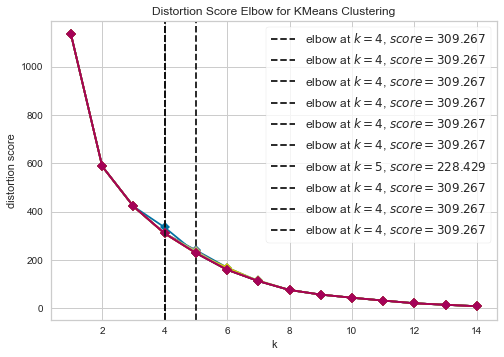

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

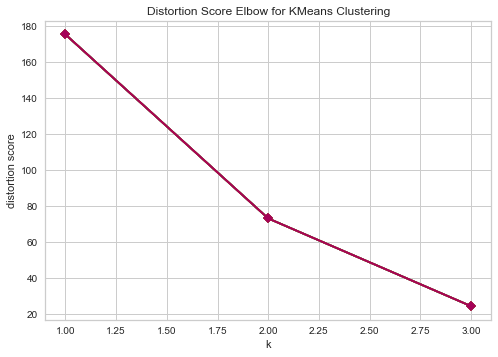

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

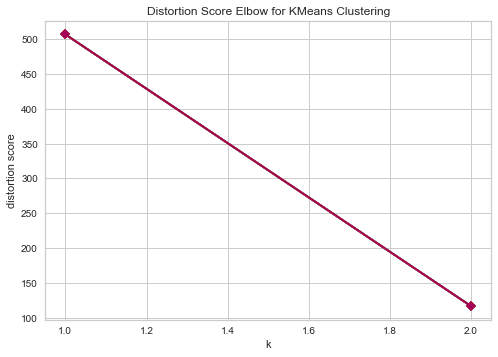

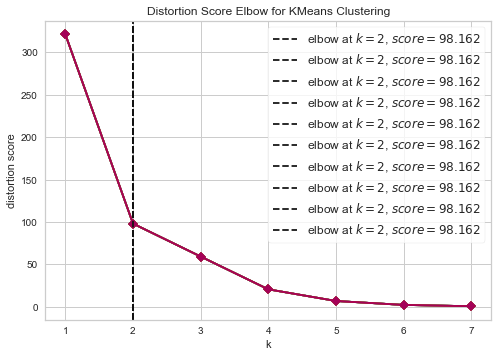

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

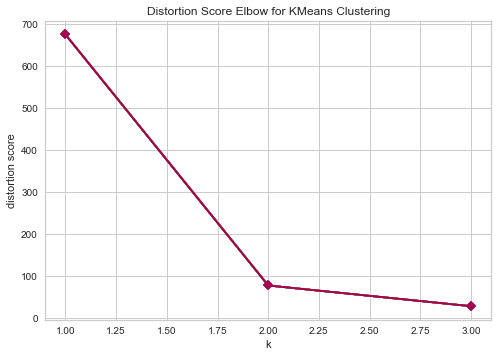

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

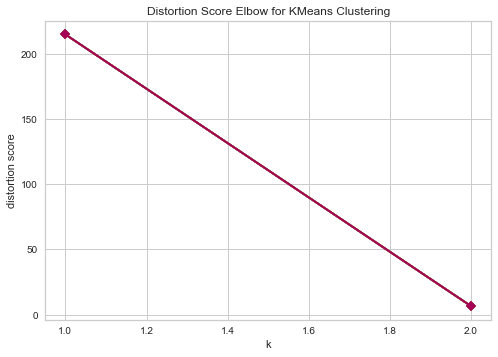

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

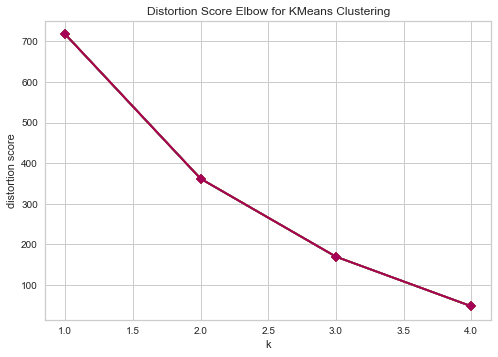

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

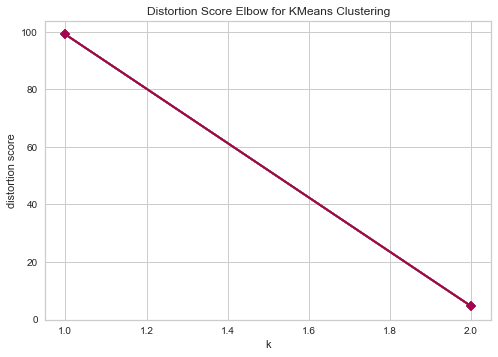

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

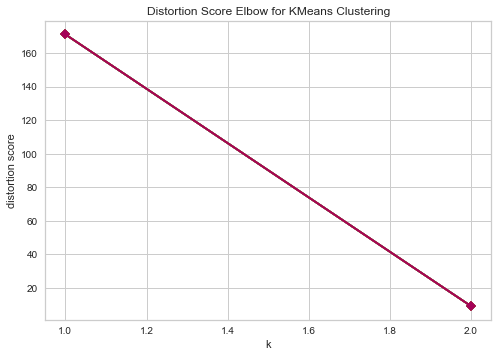

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

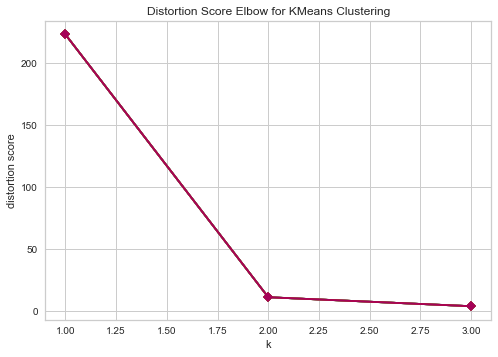

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

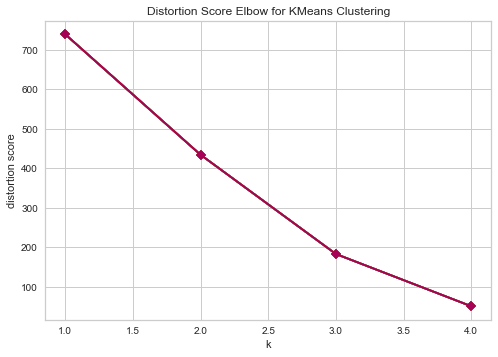

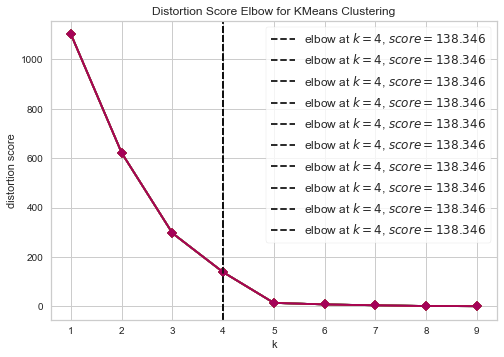

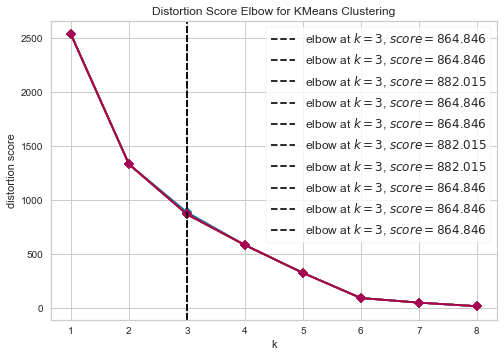

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

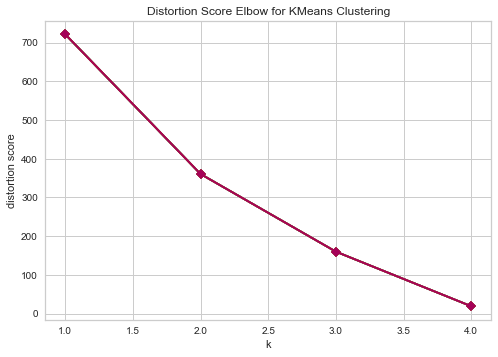

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

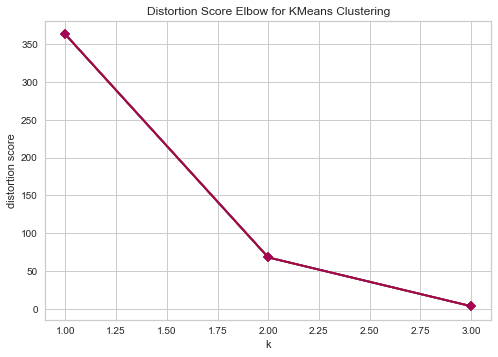

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

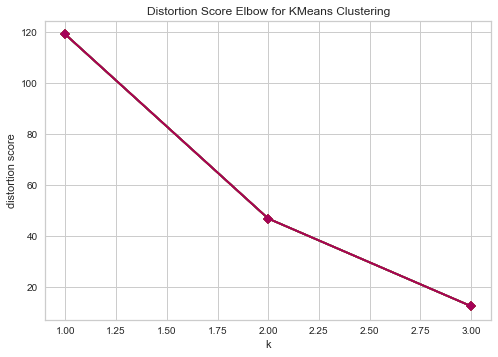

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

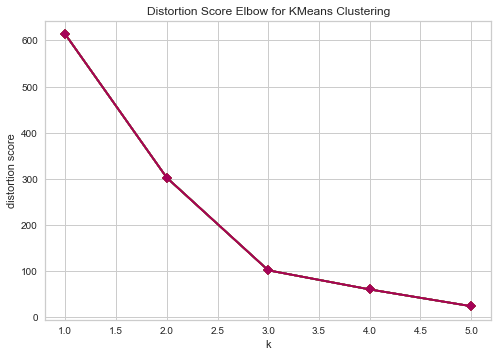

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

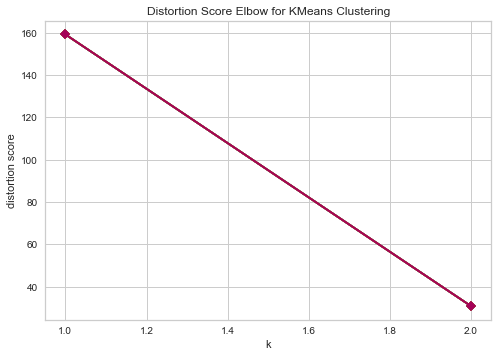

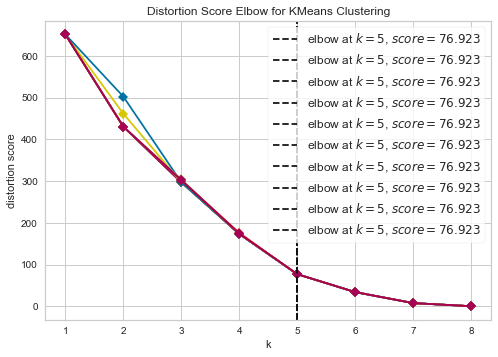

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

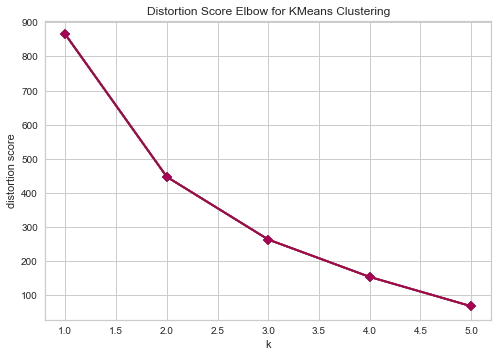

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

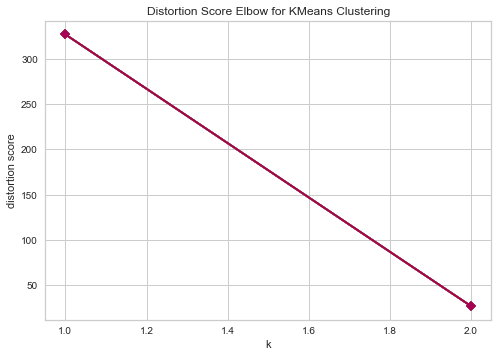

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

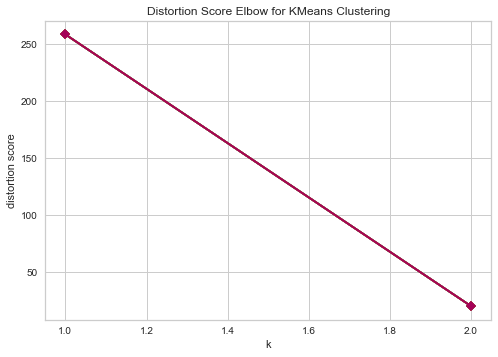

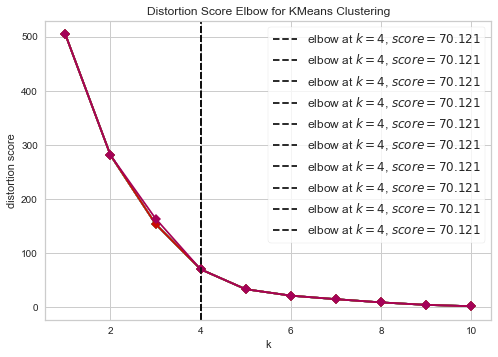

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

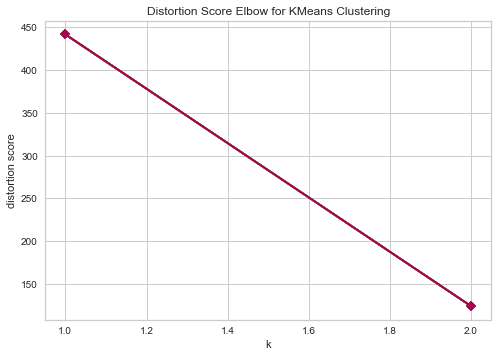

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

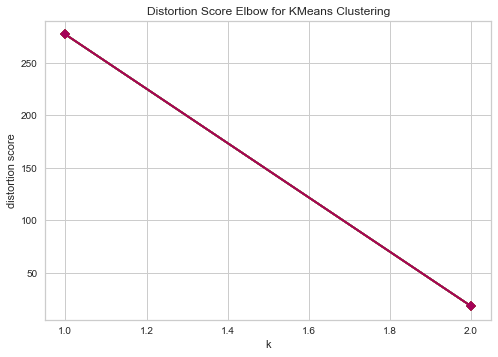

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

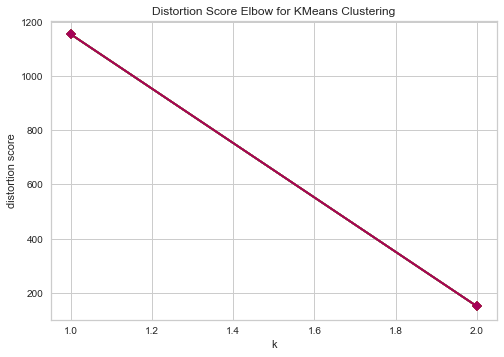

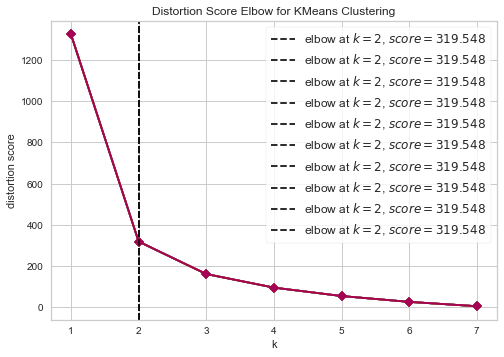

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

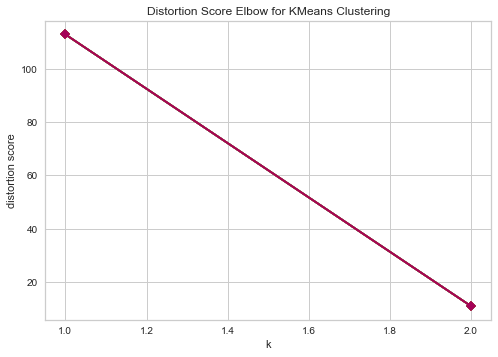

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

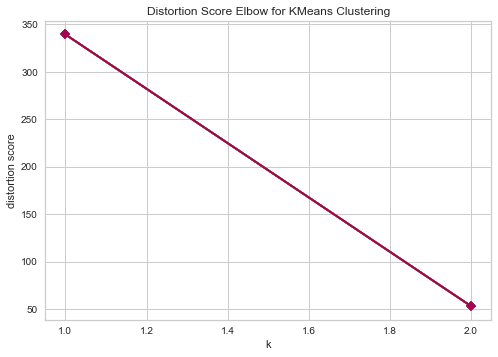

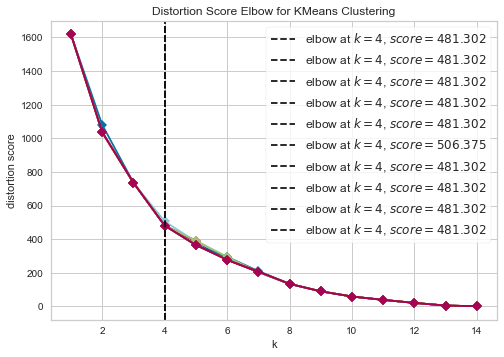

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

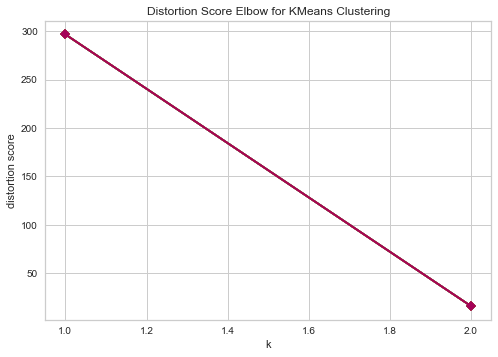

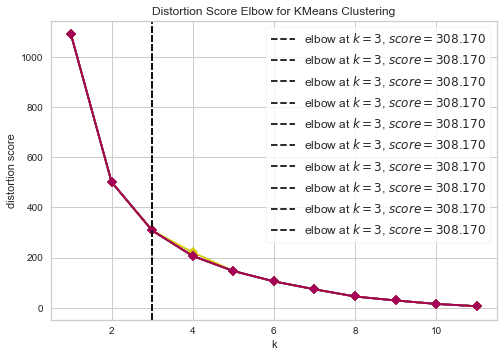

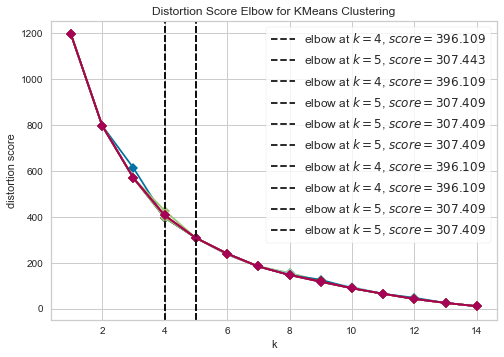

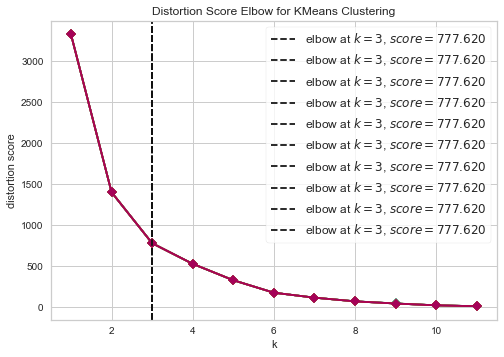

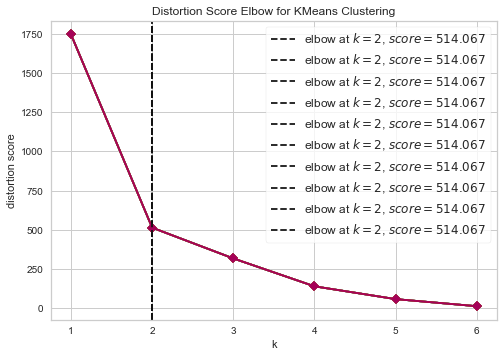

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

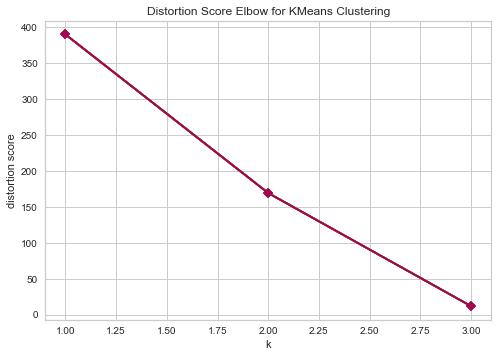

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

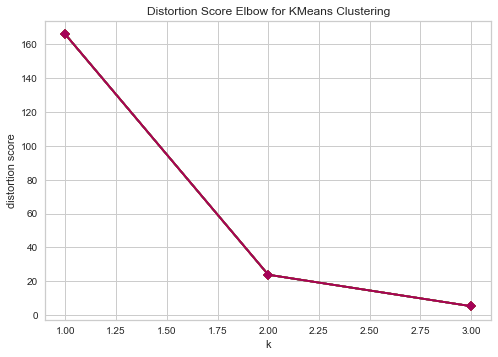

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

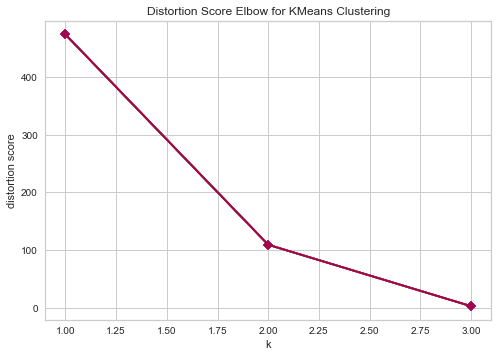

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

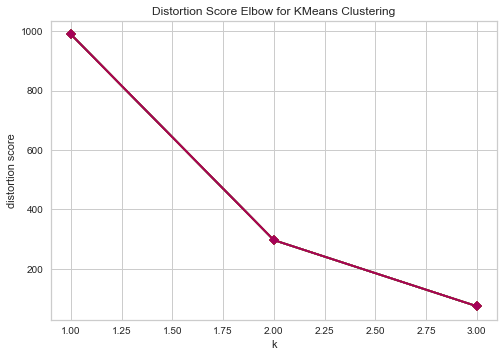

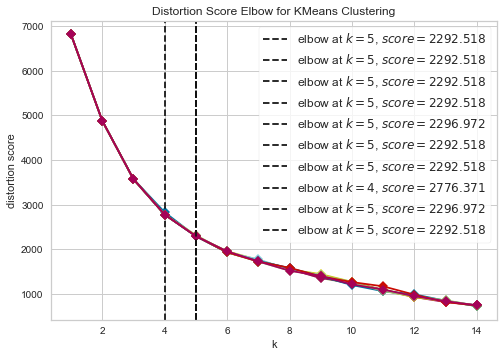

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

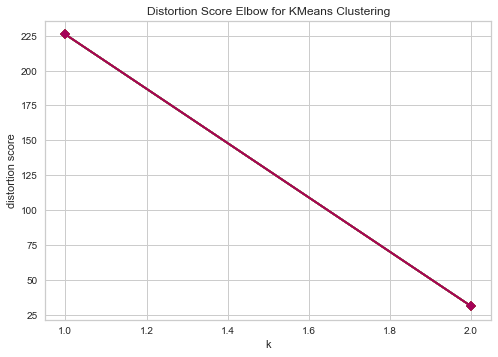

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

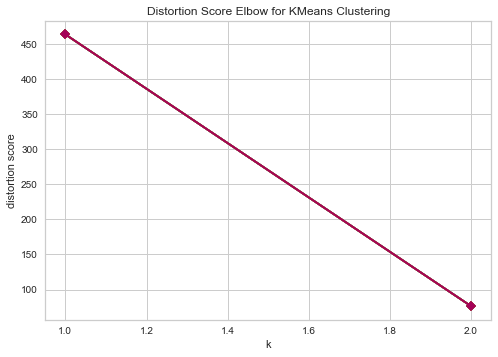

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

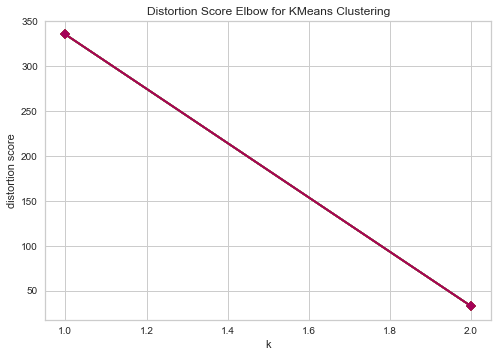

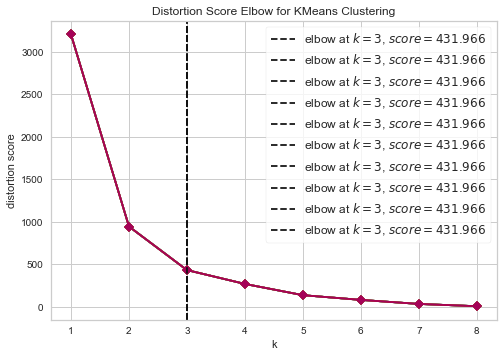

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

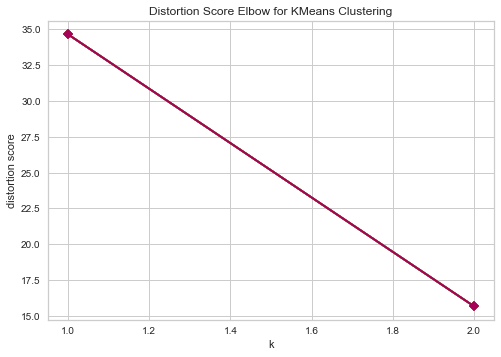

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

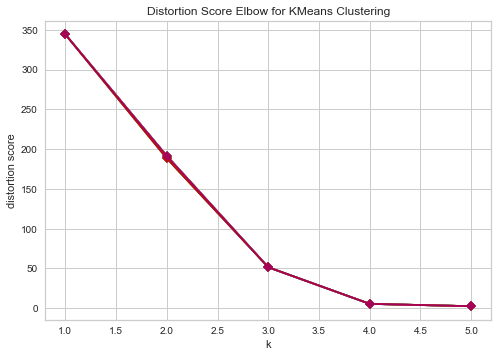

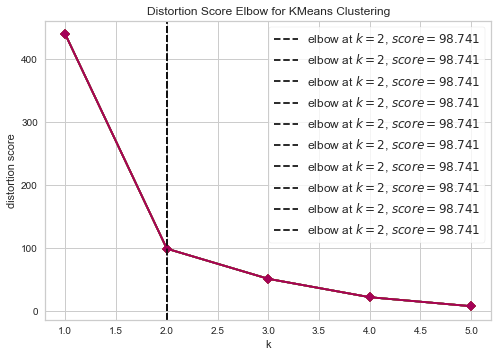

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

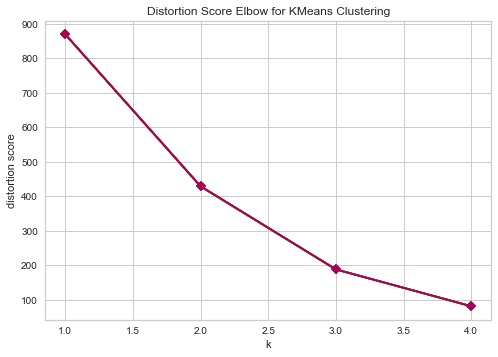

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

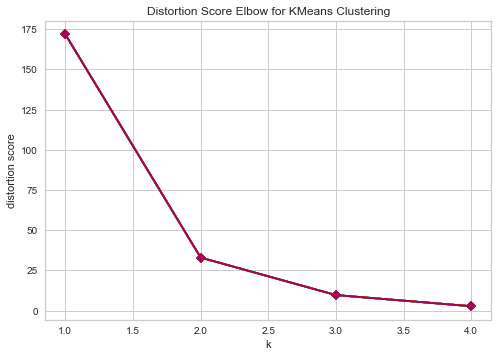

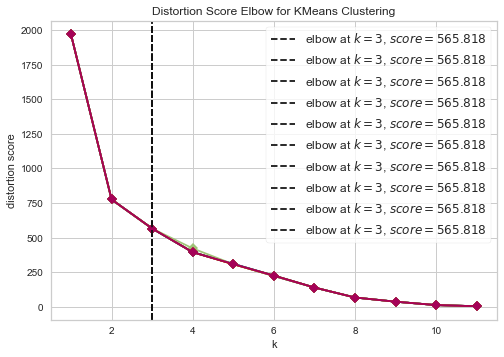

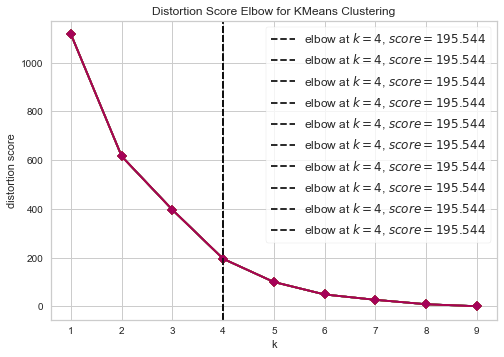

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

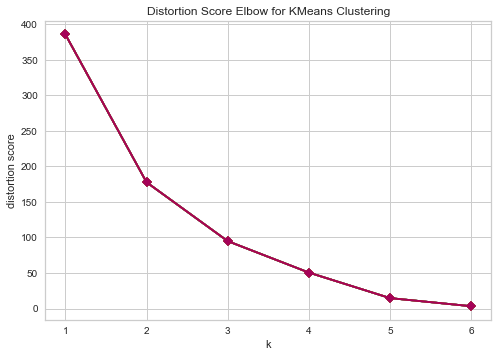

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

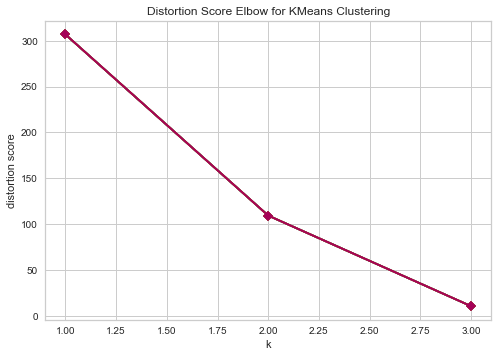

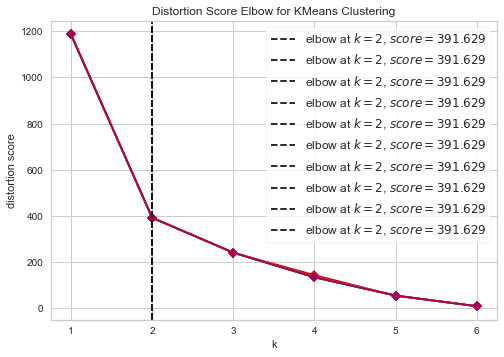

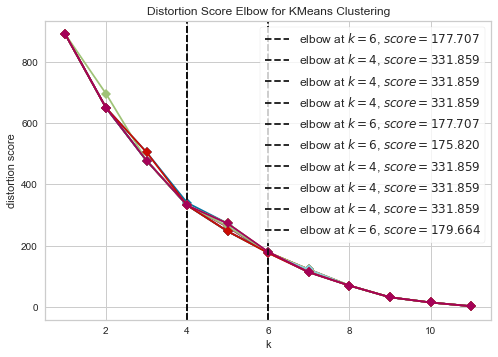

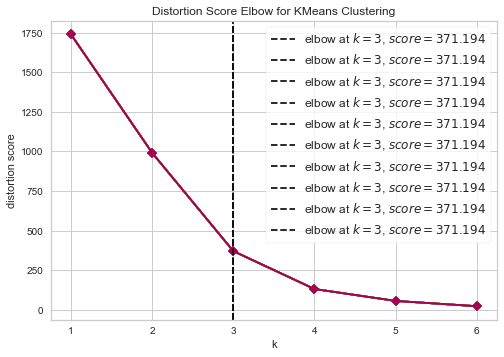

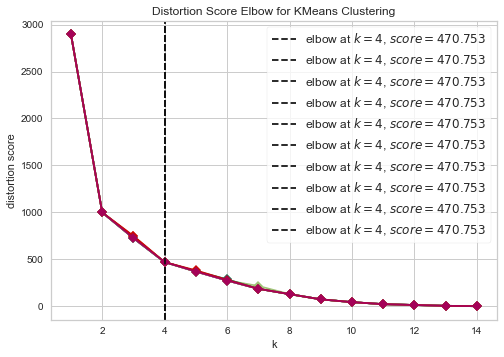

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

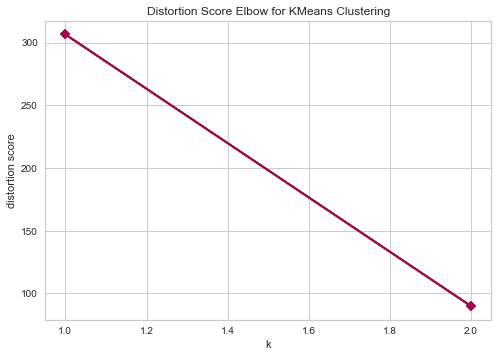

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.

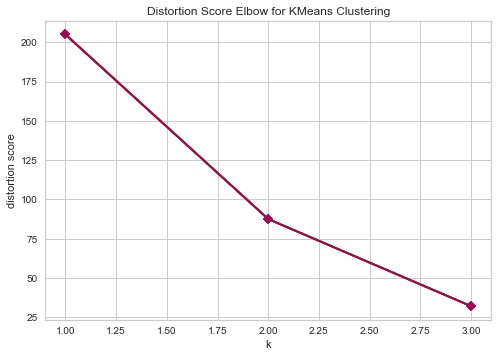

C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\jpsan\anaconda3\envs\projetos\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being 

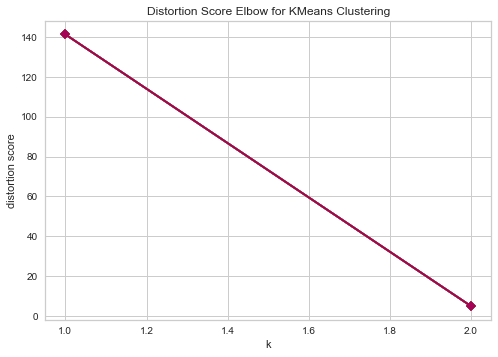

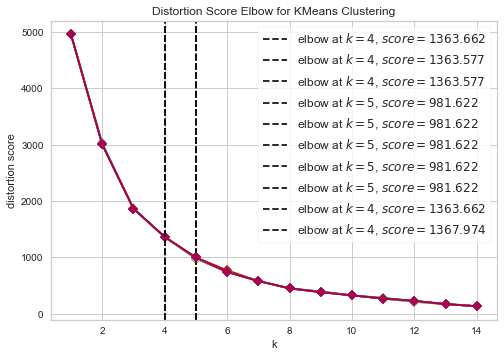

,id_sent,word_embedding_tupla_completa,num_tuplas_extraidas,num_tuplas_candidatas,categoria_num_tuplas
0,1,"[[0.40997168, -0.1877867, -0.18110998, 3.42537...",2,1,<= 5
1,3,"[[-2.7471082, 0.36707667, -0.08808833, 1.55376...",1,1,<= 5
2,4,"[[1.3758429, 0.32460427, -0.63089854, 1.07899,...",2,-1,<= 5
3,7,"[[0.2693, 0.049049973, -1.6405033, 3.1155002, ...",2,-1,<= 5
4,9,"[[0.18686669, 0.50386995, -2.7881832, 2.194683...",1,1,<= 5


In [341]:
# for row in df_clusters.iterrows():
#     componentes = np.array(row[1]['word_embedding_tupla_completa'])
#     print("index for -> {}".format(row[0]))
#     print("index sent -a> {}".format(row[1]['id_sent']))
#     gerar_modelos_kMeans(componentes)
        
df_clusters['num_tuplas_candidatas'] = df_clusters.apply(lambda x: gerar_modelos_kMeans(np.array(x['word_embedding_tupla_completa'])), axis=1)  

df_clusters.head()


In [345]:
def categorizar_tuplas_clusters(num_tuplas):
    if num_tuplas <= 5:
        return "<= 5"
    if num_tuplas <= 10:
        return "<= 10"
    if num_tuplas <= 15:
        return "<= 15"
    if num_tuplas <= 20:
        return "<= 20"
    if num_tuplas <= 25:
        return "<= 25"
    if num_tuplas <=30:
        return "<= 30"
    if num_tuplas > 30:
        return "> 30"
    
    
df_clusters['categoria_num_tuplas'] = df_clusters.apply(lambda x: categorizar_tuplas_clusters(x['num_tuplas_extraidas']),
                                                        axis=1)

df_clusters.head()

,id_sent,word_embedding_tupla_completa,num_tuplas_extraidas,num_tuplas_candidatas,categoria_num_tuplas
0,1,"[[0.40997168, -0.1877867, -0.18110998, 3.42537...",2,1,<= 5
1,3,"[[-2.7471082, 0.36707667, -0.08808833, 1.55376...",1,1,<= 5
2,4,"[[1.3758429, 0.32460427, -0.63089854, 1.07899,...",2,-1,<= 5
3,7,"[[0.2693, 0.049049973, -1.6405033, 3.1155002, ...",2,-1,<= 5
4,9,"[[0.18686669, 0.50386995, -2.7881832, 2.194683...",1,1,<= 5


In [240]:
print("Média de tuplas extraidas: {}".format(df_clusters['num_tuplas_extraidas'].mean()))
print("Desvio Padrão: {}".format(df_clusters['num_tuplas_extraidas'].std()))


Média de tuplas extraidas: 5.471074380165289
Desvio Padrão: 8.212870367260248


In [134]:
#df_clusters['num_tuplas_extraidas'].idxmax(axis = 1)
df_clusters.loc[84]

# z = np.array([[1, 2, 3, 4],
#          [5, 6, 7, 8],
#          [9, 10, 11, 12]])

# z.shape
# z.reshape(-1)
# z.reshape(-1,1)
# z.reshape(-1, 4)
# z.reshape(1,-1)

id_sent                                                                        403
word_embedding_tupla_completa    [[-0.13844, -1.1205909, -0.9911572, 1.9135319,...
num_tuplas_extraidas                                                            66
Name: 84, dtype: object

## SALVANDO EXCEL

In [346]:
def salvar_excel(df, nome_arquivo, nome_planinha):
    with pd.ExcelWriter(nome_arquivo,
                    mode='a') as writer:  
        df.to_excel(writer, sheet_name=nome_planinha)

    
# salvar_excel(df_sentencas.drop_duplicates(subset=['nome']), "video_primo_rico.xlsx", 'Sentencas')
# salvar_excel(df_tuplas, "video_primo_rico.xlsx", 'Tuplas')
# salvar_excel(df_embeddings, "video_primo_rico.xlsx", 'Embeddings')
# salvar_excel(df_tsne, "video_primo_rico.xlsx", 'Tsne')
salvar_excel(df_clusters, "video_primo_rico.xlsx", 'sentencas_agrupada')


dict_df_pickle = {
    "df_sentencas":df_sentencas,
    "df_tuplas":df_tuplas,
    "df_embeddings":df_embeddings,
    "df_tsne":df_tsne,
    "df_clusters": df_clusters
}

with open('dict_df_pickle.pickle', 'wb') as handle:
    pickle.dump(dict_df_pickle, handle, protocol=pickle.HIGHEST_PROTOCOL)



## Lendo Excel

In [11]:
df_sentencas = pd.read_excel (r'video_primo_rico.xlsx', sheet_name='Sentencas', engine='openpyxl', index_col="index")
df_tuplas = pd.read_excel (r'video_primo_rico.xlsx', sheet_name='Tuplas', engine='openpyxl', index_col="index") 
df_embeddings = pd.read_excel (r'video_primo_rico.xlsx', sheet_name='Embeddings', engine='openpyxl', index_col="index") 
df_tsne = pd.read_excel (r'video_primo_rico.xlsx', sheet_name='Tsne', engine='openpyxl', index_col="index")

## Testes Spacy WORD VECTORS

In [25]:
texto_teste = "João mora com Maria e ambos tem um cachorro chamado Mikeson"
doc = nlp(texto_teste)
word_vector = np.vstack([word.vector for word in doc if word.has_vector])
word_vector

array([[ 2.8689  ,  4.5083  ,  3.2087  , ..., -0.84668 ,  2.5372  ,
         0.59875 ],
       [ 2.3187  , -0.79077 ,  2.2222  , ..., -2.1872  ,  2.2526  ,
        -2.4121  ],
       [ 1.2238  , -4.9726  , -1.2056  , ...,  0.99122 ,  0.89958 ,
         1.06    ],
       ...,
       [-0.57857 , -0.61289 ,  1.6791  , ...,  1.3922  , -3.8822  ,
         1.8081  ],
       [ 0.96452 , -1.9547  ,  0.50567 , ...,  0.41795 , -1.2177  ,
        -0.90015 ],
       [ 0.11781 ,  1.9147  ,  1.3317  , ..., -0.44868 , -0.079062,
         1.2945  ]], dtype=float32)

In [52]:
def obter_embedding(texto):
    return nlp(texto).vector

# def obter_vetor_pca(vetor, n_components=2):
#     pca = PCA(n_components)

#     componentes_pca = pca.fit_transform(vetor)
#     return componentes_pca


In [ ]:
# TODOs: 
- Obter vetor: DONE
- Normalizar Valores:
- Calcular PCA:



In [57]:
lst_texto = ["João mora com Maria", "João", "Maria"]
lst_array = [obter_embedding(texto) for texto in lst_texto]


In [351]:
example_1 = ("Você  tem que se perguntar Essa demissão de o Moro", "Você  tem que se perguntar Essa demissão de o Moro , o que ela impacta de fato")
example_2 = ("o mercado  é muito emocionado ", "o mercado  é muito emocionado então")


print("Jaccard"calcular_similaridade_jaccard(example_1[0], example_1[1]))



0.7692307692307693
